In [1]:
# Using lifelines package to do survival analysis.
import pandas as pd
import numpy as np
import lifelines
import lifelines.statistics
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import os
import sys
sys.path.append(os.path.abspath( '/mnt/c/Users/ochapman/Documents/Mesirov/Software/oscutils'))
import get
pd.set_option('display.max_columns', None)
#os.chdir('/home/ochapman/Documents/Mesirov/medullo_ecDNA/TCGA-lifelines-survival')
print(os.getcwd())

try:
    os.mkdir('out')
except OSError as error:
    print(error)

/mnt/c/Users/ochapman/Documents/Mesirov/medullo_ecDNA/src/survival
[Errno 17] File exists: 'out'


In [2]:
def median_time_to_event(T,E):
    medIx = np.argsort(T)[len(T)//2]
    med=T[medIx]
    obs=E[medIx]
    if obs:
        print("Median time to event:",med)
    else:
        print("Median time to event is at least:",med,"(event not observed at median)")
    return(med,obs)

In [3]:
# PFS
pfs = get.medullo_patients()
pfs.ecDNA = pfs.ecDNA.map({
    'yes':True,
}).fillna(False).astype(bool)
pfs = pfs.dropna(subset=['Survival_time_years','ecDNA'])
pfs.Relapse_status = pfs.apply(axis=1,
                               func=lambda x:  not (np.isnan(x["Relapse_interval_years"])))
pfs['Relapse_interval_years'] = pfs.apply(axis=1,
                                          func=lambda x: x['Survival_time_years'] if np.isnan(x['Relapse_interval_years']) else x['Relapse_interval_years'])
pfs

,Source,ecDNA,Subgroup,Sex,Age_at_diagnosis,Vital_status,Relapse_status,Relapse_interval_years,Survival_time_years,Citations,Subtype_northcott,Aliases
Patient_ID,,,,,,,,,,,,
MB018,Archer,False,G3,f,13.00,alive,False,7.000000,7.000000,"1,2",II,DO35553
MB036,Archer,True,G3,m,4.00,alive,False,6.000000,6.000000,"1,2",II,DO35573
MB037,Archer,False,SHH,f,1.00,alive,False,7.000000,7.000000,"1,2",SHH (infant),DO35574
MB088,Archer,False,SHH,m,2.00,alive,True,0.668036,6.000000,"1,2",SHH (infant),DO35620
MB091,Archer,False,G4,m,15.00,alive,False,6.000000,6.000000,"1,2",VIII,DO35623
...,...,...,...,...,...,...,...,...,...,...,...,...
SJ008038,St Jude,True,G4,m,8.70,alive,False,1.916667,1.916667,4,NaN,NaN
SJ008039,St Jude,False,G3,m,8.19,alive,False,2.000000,2.000000,4,NaN,NaN
SJ008040,St Jude,False,WNT,f,8.14,alive,False,1.750000,1.750000,4,NaN,NaN


ecDNA+ PFS:
Median time to event is at least: 2.0 (event not observed at median)
ecDNA- PFS:
Median time to event is at least: 2.79260780287474 (event not observed at median)


(2.79260780287474, False)

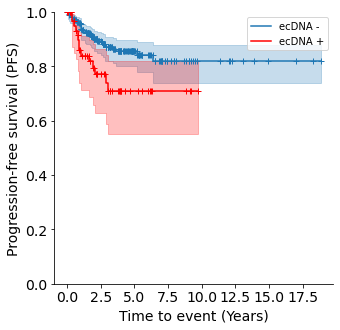

In [4]:
kmf = lifelines.KaplanMeierFitter()

ix = pfs['ecDNA']
T = pfs['Relapse_interval_years']
E = pfs['Relapse_status']

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_ylim([0.0, 1.0])

kmf.fit(T[~ix], E[~ix], label='ecDNA -')
ax = kmf.plot(ax=ax,show_censors=True,censor_styles={'ms':6})

kmf.fit(T[ix], E[ix], label='ecDNA +')
ax = kmf.plot(ax=ax,show_censors=True,censor_styles={'ms':6},c="red")

sns.despine()
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
ax.set_xlabel("Time to event (Years)")
ax.set_ylabel("Progression-free survival (PFS)")
plt.savefig('out/figure1f_pfs.svg')

print("ecDNA+ PFS:")
median_time_to_event(T[ix].values,E[ix].values)
print("ecDNA- PFS:")
median_time_to_event(T[~ix].values,E[~ix].values)

In [5]:
results = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99)

results.print_summary()
print(results.p_value)
print(results.test_statistic)

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.33 0.01      6.40

0.011858719295827245
6.331870299470758


In [6]:
# OS
os_tbl = get.medullo_patients()
os_tbl.ecDNA = os_tbl.ecDNA.map({
    'yes':True,
}).fillna(False).astype(bool)
os_tbl.Vital_status = os_tbl.Vital_status.map({
    'alive':False,
    'deceased':True
}).fillna(False).astype(bool)
os_tbl = os_tbl.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])
#os

ecDNA+ OS:
Median time to event: 2.0
ecDNA- OS:
Median time to event is at least: 3.0 (event not observed at median)


(3.0, False)

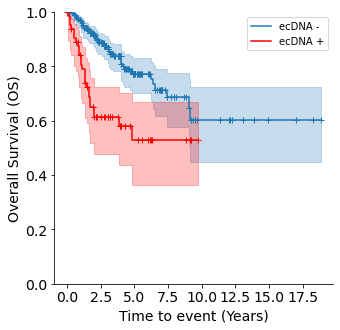

In [7]:
kmf_os = lifelines.KaplanMeierFitter()

ix = os_tbl['ecDNA']
T = os_tbl['Survival_time_years']
E = os_tbl['Vital_status']

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_ylim([0.0, 1.0])

kmf_os.fit(T[~ix], E[~ix], label='ecDNA -')
ax = kmf_os.plot(ax=ax,show_censors=True,censor_styles={'ms':6})

kmf_os.fit(T[ix], E[ix], label='ecDNA +')
ax = kmf_os.plot(ax=ax,show_censors=True,censor_styles={'ms':6},c="red")

sns.despine()
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
ax.set_xlabel("Time to event (Years)")
ax.set_ylabel("Overall Survival (OS)")
plt.savefig('out/figure1e_os.svg')

print("ecDNA+ OS:")
median_time_to_event(T[ix].values,E[ix].values)
print("ecDNA- OS:")
median_time_to_event(T[~ix].values,E[~ix].values)

In [8]:
results = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99)

results.print_summary()
print(results.p_value)        
print(results.test_statistic)

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          19.44 <0.005     16.55

1.0400026166536982e-05
19.43650157256906


In [9]:
# Cox regression: need to one-hot encode categorical (Subgroup) and Sex. Age as integer.
# PFS
pfs = get.medullo_patients()
pfs.ecDNA = pfs.ecDNA.map({
    'yes':True,
}).fillna(False).astype(bool)
pfs = pfs.dropna(subset=['Survival_time_years','ecDNA','Subgroup','Sex','Age_at_diagnosis'])
pfs.Relapse_status = pfs.apply(axis=1,
                               func=lambda x:  not (np.isnan(x["Relapse_interval_years"])))
pfs['Relapse_interval_years'] = pfs.apply(axis=1,
                                          func=lambda x: x['Survival_time_years'] if np.isnan(x['Relapse_interval_years']) else x['Relapse_interval_years'])

#pfs["age"] = pfs["Age at diagnosis (Archer age)"].map(lambda x: float(str(x).split()[0]))
pfs["Sex"] = pfs["Sex"].map({
    "f":0,
    "m":1,
}).astype(int)
pfs["WNT"] = pfs["Subgroup"] == 'WNT'
pfs["SHH"] = pfs["Subgroup"] == 'SHH'
pfs["G3"] = pfs["Subgroup"] == "G3"
pfs["G4"] = pfs["Subgroup"] == 'G4'

pfs = pfs[["ecDNA","Relapse_interval_years","Relapse_status","Age_at_diagnosis","Sex","SHH","G3"]]

pfs

,ecDNA,Relapse_interval_years,Relapse_status,Age_at_diagnosis,Sex,SHH,G3
Patient_ID,,,,,,,
MB018,False,7.000000,False,13.00,0,False,True
MB036,True,6.000000,False,4.00,1,False,True
MB037,False,7.000000,False,1.00,0,True,False
MB088,False,0.668036,True,2.00,1,True,False
MB091,False,6.000000,False,15.00,1,False,False
...,...,...,...,...,...,...,...
SJ008038,True,1.916667,False,8.70,1,False,False
SJ008039,False,2.000000,False,8.19,1,False,True
SJ008040,False,1.750000,False,8.14,0,False,False


In [10]:
cph = CoxPHFitter()
cph.fit(pfs, duration_col='Relapse_interval_years', event_col='Relapse_status')

cph.print_summary()  # access the results using cph.summary
cph.summary.to_csv('out/2021-02-22_pfs_cox_regression.tsv',sep='\t')

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 356 total observations, 308 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
      baseline estimation = breslow
   number of observations = 356
number of events observed = 48
   partial log-likelihood = -257.06
         time fit was run = 2022-03-29 20:48:30 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
ecDNA              0.67       1.96       0.32             0.04             1.31                 1.04                 3.70
Age_at_diagnosis  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Sex               -0.14       0.87       0.30            -0.73             0.44                 0.48                 1.56
SHH                0.81       2.24       0.35             0.11             1.50                 1.12                 4.46
G3                 0.58       1.79       0.39            -0.18             1.34                 0.84                 3.83

                     z    p   -log2(p)
covariate                             
ecDNA             2.07 0.04       4.71
Age_at_diagnosis -0.37 0.71       0.50
Sex              -0.47 0.64       0.65
SHH               2.29 0.02       5.49
G3                1.50 0.13       2.90
---
Concordance = 0.66
Partial AIC = 524.12
log-likelihood ratio test = 12.58 on 5 df
-log2(p) of ll-ratio test = 5.18

In [11]:
# Cox regression: need to one-hot encode categorical (Subgroup) and Sex. Format Age as integer.
# OS
os_tbl = get.medullo_patients()
os_tbl.ecDNA = os_tbl.ecDNA.map({
    'yes':True,
}).fillna(False).astype(bool)
os_tbl.Vital_status = os_tbl.Vital_status.map({
    'alive':False,
    'deceased':True
}).fillna(False).astype(bool)
os_tbl = os_tbl.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])

os_tbl = os_tbl.dropna(subset=["Age_at_diagnosis","Sex","Subgroup"])
os_tbl["Sex"] = os_tbl["Sex"].map({
    "f":0,
    "m":1,
}).astype(int)
os_tbl["WNT"] = os_tbl["Subgroup"] == 'WNT'
os_tbl["SHH"] = os_tbl["Subgroup"] == 'SHH'
os_tbl["G3"] = os_tbl["Subgroup"] == "G3"
os_tbl["G4"] = os_tbl["Subgroup"] == 'G4'


os_tbl = os_tbl[["ecDNA","Vital_status","Survival_time_years","Age_at_diagnosis","Sex","SHH","G3"]]

os_tbl

,ecDNA,Vital_status,Survival_time_years,Age_at_diagnosis,Sex,SHH,G3
Patient_ID,,,,,,,
MB018,False,False,7.000000,13.00,0,False,True
MB036,True,False,6.000000,4.00,1,False,True
MB037,False,False,7.000000,1.00,0,True,False
MB088,False,False,6.000000,2.00,1,True,False
MB091,False,False,6.000000,15.00,1,False,False
...,...,...,...,...,...,...,...
SJ008038,True,False,1.916667,8.70,1,False,False
SJ008039,False,False,2.000000,8.19,1,False,True
SJ008040,False,False,1.750000,8.14,0,False,False


In [12]:
cph = CoxPHFitter()
cph.fit(os_tbl, duration_col='Survival_time_years', event_col='Vital_status')

cph.print_summary()  # access the results using cph.summary
cph.summary.to_csv('out/2020-02-22_os_cox_regression.tsv',sep='\t')

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 356 total observations, 283 right-censored observations>
             duration col = 'Survival_time_years'
                event col = 'Vital_status'
      baseline estimation = breslow
   number of observations = 356
number of events observed = 73
   partial log-likelihood = -361.07
         time fit was run = 2022-03-29 20:48:33 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
ecDNA              1.13       3.11       0.25             0.64             1.63                 1.89                 5.12
Age_at_diagnosis   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Sex               -0.28       0.75       0.24            -0.76             0.19                 0.47                 1.21
SHH                0.66       1.93       0.33             0.01             1.31                 1.01                 3.69
G3                 1.62       5.07       0.29             1.05             2.20                 2.85                 9.02

                     z      p   -log2(p)
covariate                               
ecDNA             4.46 <0.005      16.88
Age_at_diagnosis  2.01   0.04       4.50
Sex              -1.16   0.24       2.03
SHH               1.99   0.05       4.42
G3                5.53 <0.005      24.87
---
Concordance = 0.76
Partial AIC = 732.15
log-likelihood ratio test = 49.84 on 5 df
-log2(p) of ll-ratio test = 29.32